In [2]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
data_dir = 'E:\数据集\cifar-10'

In [ ]:
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

In [7]:
#@save
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

#@save
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                     'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
    return n_valid_per_label

In [8]:
#@save
def reorg_test(data_dir):
    """在预测期间整理测试集，以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test',
                              'unknown'))

In [9]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [11]:
batch_size = 32 
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [12]:
transform_train = torchvision.transforms.Compose([
    # 在高度和宽度上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高度和宽度均为40像素的正方形图像，
    # 生成一个面积为原始图像面积0.64～1倍的小正方形，
    # 然后将其缩放为高度和宽度均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [13]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [14]:
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [15]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [16]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")

In [17]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

In [ ]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

毕节滑坡的语义分割

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # 编码器
        self.enc1 = self.conv_block(3, 64)   # 输入通道数调整为 3
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.enc5 = self.conv_block(512, 1024)

        # 解码器
        self.upconv6 = self.upconv_block(1024, 512)
        self.upconv7 = self.upconv_block(512, 256)
        self.upconv8 = self.upconv_block(256, 128)
        self.upconv9 = self.upconv_block(128, 64)

        # 合并操作
        self.merge6 = self.conv_block(1024, 512, batch_norm=False)
        self.merge7 = self.conv_block(512, 256, batch_norm=False)
        self.merge8 = self.conv_block(256, 128, batch_norm=False)
        self.merge9 = self.conv_block(128, 64, batch_norm=False)

        # 输出层
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels, batch_norm=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batch_norm:
            layers.insert(2, nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # 编码
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        enc5 = self.enc5(F.max_pool2d(enc4, 2))

        # 解码
        up6 = self.upconv6(enc5)
        merge6 = torch.cat([up6, enc4], dim=1)
        conv6 = self.merge6(merge6)

        up7 = self.upconv7(conv6)
        merge7 = torch.cat([up7, enc3], dim=1)
        conv7 = self.merge7(merge7)

        up8 = self.upconv8(conv7)
        merge8 = torch.cat([up8, enc2], dim=1)
        conv8 = self.merge8(merge8)

        up9 = self.upconv9(conv8)
        merge9 = torch.cat([up9, enc1], dim=1)
        conv9 = self.merge9(merge9)

        outputs = self.final(conv9)
        return outputs

# 测试模型的定义
if __name__ == "__main__":
    model = UNet()
    x = torch.randn(4, 3, 256, 256)  # 创建一个形状为 (4, 3, 256, 256) 的输入张量
    output = model(x)
    print(output.shape)  # 应该打印 (4, 1, 256, 256)

In [1]:
#dataset.py
import os
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class LandslideDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images=os.listdir(image_dir)

        # self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')])
        # self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png') or f.endswith('.jpg')])
        
    def __len__(self):
        return len(self.image_files)
    

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_files[index])
        label_path = os.path.join(self.label_dir, self.label_files[index])
        
        image= Image.open(image_path).convert('RGB')  # 转换为RGB模式
        mask = Image.open(label_path).convert('L')  # 转换为灰度模式
        
        if self.transform is not None:
            augmentation=self.transform(iamge=image,mask=mask)
            image=augmentation("image")
            mask=augmentation("mask")
            
        return image,mask

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from tqdm import  tqdm
import random

#hyperparms
learning_rate=1e-4
batch_size=4
num_epochs=2
num_workers=2
pin_memory=False
load_model=True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
import torch.nn as nn
import torch
from osgeo import gdal
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class UNet(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(input_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)
        self.center = self.conv_block(256, 512)
        self.dec4 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec2 = self.conv_block(128 + 64, 64)
        self.dec1 = self.conv_block(64 + 32, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        self.dropout = nn.Dropout(p=0.5)
        enc1 = self.dropout(self.enc1(x))
        enc2 = self.dropout(self.enc2(self.pool(enc1)))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([enc4, self.crop_and_concat(self.up(center), enc4)], 1))
        dec3 = self.dec3(torch.cat([enc3, self.crop_and_concat(self.up(dec4), enc3)], 1))
        dec2 = self.dec2(torch.cat([enc2, self.crop_and_concat(self.up(dec3), enc2)], 1))
        dec1 = self.dec1(torch.cat([enc1, self.crop_and_concat(self.up(dec2), enc1)], 1))
        final = self.final(dec1).squeeze()

        return final
    def crop_and_concat(self, upsampled, bypass):
        # 计算要裁剪的边界
        diffY = bypass.size()[2] - upsampled.size()[2]
        diffX = bypass.size()[3] - upsampled.size()[3]

        # 裁剪输入张量
        upsampled = torch.nn.functional.pad(upsampled, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        return upsampled
class RSDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images = self.read_multiband_images(images_dir)
        self.labels = self.read_singleband_labels(labels_dir)
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image, label = self.transform(image, label)
        return torch.tensor(image), torch.tensor(label)

    def read_multiband_images(self, images_dir):
        images = []
        for image_file in os.listdir(images_dir):
            image_path = os.path.join(images_dir, image_file)
            rsdl_data = gdal.Open(image_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open image file: {image_path}")
            images.append(np.stack([rsdl_data.GetRasterBand(i).ReadAsArray() for i in range(1, 4)], axis=0))
        return images

    def read_singleband_labels(self, labels_dir):
        labels = []
        for label_file in os.listdir(labels_dir):
            label_path = os.path.join(labels_dir, label_file)
            rsdl_data = gdal.Open(label_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open label file: {label_path}")
            labels.append(rsdl_data.GetRasterBand(1).ReadAsArray())
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image), torch.tensor(label)

def get_transform():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()  # Converts the image to a PyTorch tensor
    ])
def transform(image, label):
    from PIL import Image
    image = Image.fromarray(image)
    label = Image.fromarray(label)

    transform = get_transform()
    image = transform(image)
    label = transform(label)
    
    image = np.array(image)
    label = np.array(label)
    return image, label

def custom_collate_fn(batch):
        images, labels = zip(*batch)
        images = [torch.tensor(image) for image in images]
        labels = [torch.tensor(label) for label in labels]
        
        # 找到最大宽度和高度
        max_width = max([img.shape[2] for img in images])
        max_height = max([img.shape[1] for img in images])

        padded_images = []
        padded_labels = []
        
        for img, lbl in zip(images, labels):
            # 填充图像和标签
            pad_img = torch.zeros((img.shape[0], max_height, max_width))
            pad_img[:, :img.shape[1], :img.shape[2]] = img
            pad_lbl = torch.zeros((max_height, max_width))
            pad_lbl[:lbl.shape[0], :lbl.shape[1]] = lbl
            padded_images.append(pad_img)
            padded_labels.append(pad_lbl)
        
        return torch.stack(padded_images), torch.stack(padded_labels)

images_dir = 'E:\数据集\山体滑坡数据集\landslide\image3/'
labels_dir = 'E:\数据集\山体滑坡数据集\landslide\mask3/'

transform = lambda img, lbl: transform(img, lbl)  # Apply the transformation
dataset = RSDataset(images_dir, labels_dir, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

model = UNet(3, 1).to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 300

# # 训练和测试代码
# for epoch in range(num_epochs):
#     model.train()
#     for i, (images, labels) in enumerate(trainloader):
#         images = images.float().to(device)
#         labels = labels.float().to(device) / 255.0
#         outputs = model(images)
#         labels = labels.squeeze(0)
#         loss = criterion(outputs, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         torch.cuda.empty_cache()

#     print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))

# # 保存模型
# torch.save(model.state_dict(), 'models_building_53.pth')
# def evaluate_model(model, dataloader):
#     model.eval()
#     all_labels = []
#     all_predictions = []

#     with torch.no_grad():
#         for images, labels in dataloader:
#             images = images.float().to(device)
#             labels = labels.float().to(device) / 255.0
            
#             outputs = model(images).squeeze().cpu().numpy()
#             labels = labels.squeeze().cpu().numpy()

#             all_predictions.extend(outputs.flatten())
#             all_labels.extend(labels.flatten())

#     return np.array(all_labels), np.array(all_predictions)
# early_stop_count = 0
# best_val_loss = float('inf')
# patience = 10  # 设置早停的耐心值

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.float().to(device)
        labels = labels.float().to(device) / 255.0
        outputs = model(images)
        labels = labels.squeeze(0)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    torch.save(model.state_dict(), f'models_building_{epoch + 1}.pth')
    # val_loss = evaluate_model_loss(model, val_loader)
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     early_stop_count = 0
    #     torch.save(model.state_dict(), 'best_model.pth')  # 保存最优模型
    # else:
    #     early_stop_count += 1
    #     if early_stop_count >= patience:
    #         print("Early stopping triggered.")
    #         break



    # 计算验证集损失



test_images_dir = 'E:\数据集\山体滑坡数据集\landslide\image1/'
test_labels_dir = 'E:\数据集\山体滑坡数据集\landslide\mask1/'
# 测试数据加载器
test_transform = get_transform()
test_dataset = RSDataset(test_images_dir, test_labels_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

# 评估模型
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.float().to(device)
            labels = labels.float().to(device) / 255.0
            
            outputs = model(images).squeeze().cpu().numpy()
            labels = labels.squeeze().cpu().numpy()

            all_predictions.extend(outputs.flatten())
            all_labels.extend(labels.flatten())

    return np.array(all_labels), np.array(all_predictions)

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve (AP={average_precision:.2f})')
    plt.show()

# 评估和绘制
y_true, y_scores = evaluate_model(model, test_loader)
plot_precision_recall_curve(y_true, y_scores)

In [ ]:
import torch.nn as nn
import torch
from osgeo import gdal
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class UNet(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(input_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)
        self.center = self.conv_block(256, 512)
        self.dec4 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec2 = self.conv_block(128 + 64, 64)
        self.dec1 = self.conv_block(64 + 32, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        self.dropout = nn.Dropout(p=0.5)
        enc1 = self.dropout(self.enc1(x))
        enc2 = self.dropout(self.enc2(self.pool(enc1)))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([enc4, self.crop_and_concat(self.up(center), enc4)], 1))
        dec3 = self.dec3(torch.cat([enc3, self.crop_and_concat(self.up(dec4), enc3)], 1))
        dec2 = self.dec2(torch.cat([enc2, self.crop_and_concat(self.up(dec3), enc2)], 1))
        dec1 = self.dec1(torch.cat([enc1, self.crop_and_concat(self.up(dec2), enc1)], 1))
        final = self.final(dec1).squeeze()

        return final
    def crop_and_concat(self, upsampled, bypass):
        # 计算要裁剪的边界
        diffY = bypass.size()[2] - upsampled.size()[2]
        diffX = bypass.size()[3] - upsampled.size()[3]

        # 裁剪输入张量
        upsampled = torch.nn.functional.pad(upsampled, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        return upsampled


class RSDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images = self.read_multiband_images(images_dir)
        self.labels = self.read_singleband_labels(labels_dir)
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image, label = self.transform(image, label)
        return torch.tensor(image), torch.tensor(label)

    def read_multiband_images(self, images_dir):
        images = []
        for image_file in os.listdir(images_dir):
            image_path = os.path.join(images_dir, image_file)
            rsdl_data = gdal.Open(image_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open image file: {image_path}")
            images.append(np.stack([rsdl_data.GetRasterBand(i).ReadAsArray() for i in range(1, 4)], axis=0))
        return images

    def read_singleband_labels(self, labels_dir):
        labels = []
        for label_file in os.listdir(labels_dir):
            label_path = os.path.join(labels_dir, label_file)
            rsdl_data = gdal.Open(label_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open label file: {label_path}")
            labels.append(rsdl_data.GetRasterBand(1).ReadAsArray())
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image), torch.tensor(label)

def get_transform():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()  # Converts the image to a PyTorch tensor
    ])
def transform(image, label):
    from PIL import Image
    image = Image.fromarray(image)
    label = Image.fromarray(label)

    transform = get_transform()
    image = transform(image)
    label = transform(label)
    
    image = np.array(image)
    label = np.array(label)
    return image, label

def custom_collate_fn(batch):
        images, labels = zip(*batch)
        images = [torch.tensor(image) for image in images]
        labels = [torch.tensor(label) for label in labels]
        
        # 找到最大宽度和高度
        max_width = max([img.shape[2] for img in images])
        max_height = max([img.shape[1] for img in images])

        padded_images = []
        padded_labels = []
        
        for img, lbl in zip(images, labels):
            # 填充图像和标签
            pad_img = torch.zeros((img.shape[0], max_height, max_width))
            pad_img[:, :img.shape[1], :img.shape[2]] = img
            pad_lbl = torch.zeros((max_height, max_width))
            pad_lbl[:lbl.shape[0], :lbl.shape[1]] = lbl
            padded_images.append(pad_img)
            padded_labels.append(pad_lbl)
        
        return torch.stack(padded_images), torch.stack(padded_labels)

images_dir = 'E:\\数据集\\landslide4sense2022\\train\\images/'
labels_dir = 'E:\\数据集\\landslide4sense2022\\train\\masks'

transform = lambda img, lbl: transform(img, lbl)  # Apply the transformation
dataset = RSDataset(images_dir, labels_dir, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

model = UNet(3, 1).to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.float().to(device)
        labels = labels.float().to(device) / 255.0
        outputs = model(images)
        labels = labels.squeeze(0)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    torch.save(model.state_dict(), f'models_building_{epoch + 1}.pth')



test_images_dir = 'E:\\数据集\\landslide4sense2022\\validation\\images/'
test_labels_dir = 'E:\\数据集\\landslide4sense2022\\validation\\masks/'
# 测试数据加载器
test_transform = get_transform()
test_dataset = RSDataset(test_images_dir, test_labels_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

# 评估模型
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.float().to(device)
            labels = labels.float().to(device) / 255.0
            
            outputs = model(images).squeeze().cpu().numpy()
            labels = labels.squeeze().cpu().numpy()

            all_predictions.extend(outputs.flatten())
            all_labels.extend(labels.flatten())

    return np.array(all_labels), np.array(all_predictions)

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve (AP={average_precision:.2f})')
    plt.show()

# 评估和绘制
y_true, y_scores = evaluate_model(model, test_loader)
plot_precision_recall_curve(y_true, y_scores)

In [ ]:
import torch.nn as nn
import torch
from osgeo import gdal
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义 UNet 模型（使用之前提供的 UNet 定义）
class UNet(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(input_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)
        self.center = self.conv_block(256, 512)
        self.dec4 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec2 = self.conv_block(128 + 64, 64)
        self.dec1 = self.conv_block(64 + 32, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        self.dropout = nn.Dropout(p=0.5)
        enc1 = self.dropout(self.enc1(x))
        enc2 = self.dropout(self.enc2(self.pool(enc1)))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([enc4, self.crop_and_concat(self.up(center), enc4)], 1))
        dec3 = self.dec3(torch.cat([enc3, self.crop_and_concat(self.up(dec4), enc3)], 1))
        dec2 = self.dec2(torch.cat([enc2, self.crop_and_concat(self.up(dec3), enc2)], 1))
        dec1 = self.dec1(torch.cat([enc1, self.crop_and_concat(self.up(dec2), enc1)], 1))
        final = self.final(dec1).squeeze()

        return final
    
    def crop_and_concat(self, upsampled, bypass):
        diffY = bypass.size()[2] - upsampled.size()[2]
        diffX = bypass.size()[3] - upsampled.size()[3]

        upsampled = torch.nn.functional.pad(upsampled, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

        return upsampled

# 定义数据集
class RSDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images = self.read_multiband_images(images_dir)
        self.labels = self.read_singleband_labels(labels_dir)
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image, label = self.transform(image, label)
        return torch.tensor(image), torch.tensor(label)

    def read_multiband_images(self, images_dir):
        images = []
        for image_file in os.listdir(images_dir):
            image_path = os.path.join(images_dir, image_file)
            rsdl_data = gdal.Open(image_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open image file: {image_path}")
            images.append(np.stack([rsdl_data.GetRasterBand(i).ReadAsArray() for i in range(1, 4)], axis=0))
        return images

    def read_singleband_labels(self, labels_dir):
        labels = []
        for label_file in os.listdir(labels_dir):
            label_path = os.path.join(labels_dir, label_file)
            rsdl_data = gdal.Open(label_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open label file: {label_path}")
            labels.append(rsdl_data.GetRasterBand(1).ReadAsArray())
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image), torch.tensor(label)

# 定义数据增强和变换
def get_transform():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

def transform(image, label):
    from PIL import Image
    image = Image.fromarray(image)
    label = Image.fromarray(label)

    transform = get_transform()
    image = transform(image)
    label = transform(label)
    
    image = np.array(image)
    label = np.array(label)
    return image, label

# 定义自定义 collate 函数
def custom_collate_fn(batch):
        images, labels = zip(*batch)
        images = [image.clone().detach() for image in images]
        labels = [label.clone().detach() for label in labels]
        
        max_width = max([img.shape[2] for img in images])
        max_height = max([img.shape[1] for img in images])

        padded_images = []
        padded_labels = []
        
        for img, lbl in zip(images, labels):
            pad_img = torch.zeros((img.shape[0], max_height, max_width))
            pad_img[:, :img.shape[1], :img.shape[2]] = img
            pad_lbl = torch.zeros((max_height, max_width))
            pad_lbl[:lbl.shape[0], :lbl.shape[1]] = lbl
            padded_images.append(pad_img)
            padded_labels.append(pad_lbl)
        
        return torch.stack(padded_images), torch.stack(padded_labels)

# 定义训练参数和数据加载器
images_dir = 'E:\\数据集\\landslide4sense2022\\train\\images/'
labels_dir = 'E:\\数据集\\landslide4sense2022\\train\\masks'

transform = lambda img, lbl: transform(img, lbl)
dataset = RSDataset(images_dir, labels_dir, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

model = UNet(input_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.float().to(device)
        labels = labels.float().to(device) / 255.0
        outputs = model(images)
        labels = labels.squeeze(0)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    torch.save(model.state_dict(), f'models_building_{epoch + 1}.pth')

# 测试代码
test_images_dir = 'E:\\数据集\\landslide4sense2022\\validation\\images/'
test_labels_dir = 'E:\\数据集\\landslide4sense2022\\validation\\masks/'
test_transform = get_transform()
test_dataset = RSDataset(test_images_dir, test_labels_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.float().to(device)
            labels = labels.float().to(device) / 255.0
            
            outputs = model(images).squeeze().cpu().numpy()
            labels = labels.squeeze().cpu().numpy()

            all_predictions.extend(outputs.flatten())
            all_labels.extend(labels.flatten())

    return np.array(all_labels), np.array(all_predictions)

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve (AP={average_precision:.2f})')
    plt.show()
print(precision)
y_true, y_scores = evaluate_model(model, test_loader)
plot_precision_recall_curve(y_true, y_scores)

In [ ]:
import torch.nn as nn
import torch
from osgeo import gdal
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义 UNet 模型（使用之前提供的 UNet 定义）
class UNet(nn.Module):
    def __init__(self, input_channels, out_channels):
        super(UNet, self).__init__()

        self.enc1 = self.conv_block(input_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128, 256)
        self.center = self.conv_block(256, 512)
        self.dec4 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec2 = self.conv_block(128 + 64, 64)
        self.dec1 = self.conv_block(64 + 32, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        self.dropout = nn.Dropout(p=0.5)
        enc1 = self.dropout(self.enc1(x))
        enc2 = self.dropout(self.enc2(self.pool(enc1)))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        center = self.center(self.pool(enc4))

        dec4 = self.dec4(torch.cat([enc4, self.crop_and_concat(self.up(center), enc4)], 1))
        dec3 = self.dec3(torch.cat([enc3, self.crop_and_concat(self.up(dec4), enc3)], 1))
        dec2 = self.dec2(torch.cat([enc2, self.crop_and_concat(self.up(dec3), enc2)], 1))
        dec1 = self.dec1(torch.cat([enc1, self.crop_and_concat(self.up(dec2), enc1)], 1))
        final = self.final(dec1).squeeze()

        return final
    
    def crop_and_concat(self, upsampled, bypass):
        diffY = bypass.size()[2] - upsampled.size()[2]
        diffX = bypass.size()[3] - upsampled.size()[3]
        upsampled = torch.nn.functional.pad(upsampled, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        return upsampled

# 定义数据集
class RSDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images = self.read_multiband_images(images_dir)
        self.labels = self.read_singleband_labels(labels_dir)
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image, label = self.transform(image, label)
        return torch.tensor(image), torch.tensor(label)

    def read_multiband_images(self, images_dir):
        images = []
        for image_file in os.listdir(images_dir):
            image_path = os.path.join(images_dir, image_file)
            rsdl_data = gdal.Open(image_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open image file: {image_path}")
            images.append(np.stack([rsdl_data.GetRasterBand(i).ReadAsArray() for i in range(1, 4)], axis=0))
        return images

    def read_singleband_labels(self, labels_dir):
        labels = []
        for label_file in os.listdir(labels_dir):
            label_path = os.path.join(labels_dir, label_file)
            rsdl_data = gdal.Open(label_path)
            if rsdl_data is None:
                raise FileNotFoundError(f"Unable to open label file: {label_path}")
            labels.append(rsdl_data.GetRasterBand(1).ReadAsArray())
        return labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image), torch.tensor(label)

# 定义数据增强和变换
def get_transform():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])

def transform(image, label):
    from PIL import Image
    image = Image.fromarray(image)
    label = Image.fromarray(label)

    transform = get_transform()
    image = transform(image)
    label = transform(label)
    
    image = np.array(image)
    label = np.array(label)
    return image, label

# 定义自定义 collate 函数
def custom_collate_fn(batch):
        images, labels = zip(*batch)
        images = [image.clone().detach() for image in images]
        labels = [label.clone().detach() for label in labels]
        
        max_width = max([img.shape[2] for img in images])
        max_height = max([img.shape[1] for img in images])

        padded_images = []
        padded_labels = []
        
        for img, lbl in zip(images, labels):
            pad_img = torch.zeros((img.shape[0], max_height, max_width))
            pad_img[:, :img.shape[1], :img.shape[2]] = img
            pad_lbl = torch.zeros((max_height, max_width))
            pad_lbl[:lbl.shape[0], :lbl.shape[1]] = lbl
            padded_images.append(pad_img)
            padded_labels.append(pad_lbl)
        
        return torch.stack(padded_images), torch.stack(padded_labels)

# 定义训练参数和数据加载器
images_dir = 'E:\\数据集\\山体滑坡数据集\\landslide\\image3'
labels_dir = 'E:\\数据集\\山体滑坡数据集\\landslide\\mask3'

transform = lambda img, lbl: transform(img, lbl)
dataset = RSDataset(images_dir, labels_dir, transform=transform)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

model = UNet(input_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 500

def calculate_precision(outputs, labels):
    # 使用detach()去除梯度追踪，然后转换为numpy
    outputs = torch.sigmoid(outputs).detach().cpu().numpy().flatten() > 0.5
    labels = labels.detach().cpu().numpy().flatten()
    
    # 计算精度，添加 zero_division 参数以处理除以零的情况
    precision = precision_score(labels, outputs, zero_division=1)
    return precision
    
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_precision = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images = images.float().to(device)
        labels = labels.float().to(device) / 255.0
        outputs = model(images)
        labels = labels.squeeze(0)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache()
        running_loss += loss.item()

        precision = calculate_precision(outputs, labels)
        running_precision += precision

    epoch_precision = running_precision / len(trainloader)    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Precision: {epoch_precision:.4f}')
    torch.save(model.state_dict(), f'models_building_{epoch + 1}.pth')

# 测试代码
test_images_dir = 'E:\\数据集\\山体滑坡数据集\\landslide\\image1'
test_labels_dir = 'E:\\数据集\\山体滑坡数据集\\landslide\\mask1'
test_transform = get_transform()
test_dataset = RSDataset(test_images_dir, test_labels_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False, collate_fn=custom_collate_fn)

def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.float().to(device)
            labels = labels.float().to(device) / 255.0
            
            outputs = model(images).squeeze().cpu().numpy()
            labels = labels.squeeze().cpu().numpy()

            all_predictions.extend(outputs.flatten())
            all_labels.extend(labels.flatten())

    return np.array(all_labels), np.array(all_predictions)

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure()
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve (AP={average_precision:.2f})')
    plt.show()
print(precision)
y_true, y_scores = evaluate_model(model, test_loader)
plot_precision_recall_curve(y_true, y_scores)

In [ ]:
from PIL import Image

def convert_to_black_and_white(input_image_path, output_image_path):
    # 打开原始图像
    image = Image.open(input_image_path)
    
    # 转换为黑白图像
    bw_image = image.convert('L')
    
    # 保存黑白图像
    bw_image.save(output_image_path)
    
    print(f"黑白图像已保存到 {output_image_path}")

# 使用示例
input_image_path = 'E:\\repository\\unet.png'
output_image_path = 'black_and_white_image.jpg'
convert_to_black_and_white(input_image_path, output_image_path)

In [ ]:
#两数相加
class ListNode:
    def __init__(self, val=0, next=None):
        self.val = val
        self.next = next

class Solution:
    def addTwoNumbers(self, l1, l2):
        dummy_head = ListNode(0)
        current = dummy_head
        carry = 0

        while l1 or l2 or carry:
            val1 = l1.val if l1 else 0
            val2 = l2.val if l2 else 0

            total = val1 + val2 + carry
            carry = total // 10
            current.next = ListNode(total % 10)
            current = current.next

            if l1:
                l1 = l1.next
            if l2:
                l2 = l2.next

        return dummy_head.next


Solution=Solution()
l1 = [2,4,3]
l2 = [5,6,4]
print(Solution.addTwoNumbers(l1,l2))

















In [ ]:
"""
---
title: Compressive Transformer
summary: >
  Documented implementation with explanations of a
  Compressive Transformer model.
---

# Compressive Transformer

This is an implementation of
[Compressive Transformers for Long-Range Sequence Modelling](https://arxiv.org/abs/1911.05507)
in [PyTorch](https://pytorch.org).

This is an extension of [Transformer XL](../xl/index.html) where past memories
are compressed to give a longer attention range.
That is, the furthest $n_{cm} c$ memories are compressed into
$n_{cm}$ memories, where $c$ is the compression rate.

## Compression operation

The compression operation is defined as
$f_c: \mathbb{R}^{nc \times d} \rightarrow \mathbb{R}^{n \times d}$.
The paper introduces multiple choices for $f_c$ and we have only implemented
1D convolution which seems to give the best results.
Each layer has a separate compression operation $f_c^{(i)}$ where
$i$ is the layer number.

## Training compression operation

Since training compression with BPTT requires maintaining
a very large computational graph (many time steps), the paper proposes
an *auto-encoding loss* and an *attention reconstruction loss*.
The auto-encoding loss decodes the original memories from the compressed memories
and calculates the loss.
Attention reconstruction loss computes the multi-headed attention results
on the compressed memory and on uncompressed memory and gets a mean squared error
between them.
We have implemented the latter here since it gives better results.

This implementation uses pre-layer normalization
while the paper uses post-layer normalization.
Pre-layer norm does the layer norm before [FFN](../feedforward.html) and
self-attention, and the pass-through in the residual connection is not normalized.
This is supposed to be more stable in standard transformer setups.

Here are [the training code](experiment.html) and a notebook for training a compressive transformer
model on the Tiny Shakespeare dataset.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/transformers/compressive/experiment.ipynb)
"""

from typing import Optional, List

import torch
import torch.nn.functional as F
from torch import nn

from labml_helpers.module import Module, TypedModuleList
from labml_nn.transformers.feed_forward import FeedForward
from labml_nn.transformers.mha import PrepareForMultiHeadAttention
from labml_nn.transformers.xl.relative_mha import RelativeMultiHeadAttention
from labml_nn.utils import clone_module_list


class Conv1dCompression(Module):
    """
    ## 1D Convolution Compression $f_c$

    This is a simple wrapper around
    [`nn.Conv1d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)
    with some tensor dimension permutations.
    """
    def __init__(self, compression_rate: int, d_model: int):
        """
        * `compression_rate` $c$
        * `d_model` is the embedding size
        """
        super().__init__()
        self.conv = nn.Conv1d(d_model, d_model, kernel_size=compression_rate, stride=compression_rate)

    def forward(self, mem: torch.Tensor):
        """
        `mem` has shape `[seq_len, batch, d_model]`
        """

        # Permute the dimensions of `mem` so that we can run it through the convolution layer.
        # The convolution layer accepts in the form `[batch, features, sequence]`
        mem = mem.permute(1, 2, 0)
        # Get compressed memory by running it through the convolution layer
        c_mem = self.conv(mem)
        # Permute back to form `[seq_len, batch, d_model]`
        return c_mem.permute(2, 0, 1)


class CompressiveTransformerLayer(Module):
    """
    ## Compressive Transformer Layer

    This is the implementation of a single compressive transformer layer
    """
    def __init__(self, *,
                 d_model: int,
                 self_attn: RelativeMultiHeadAttention,
                 feed_forward: FeedForward,
                 dropout_prob: float,
                 compress: Conv1dCompression):
        """
        * `d_model` is the token embedding size
        * `self_attn` is the [self attention module](../xl/relative_mha.html)
        * `feed_forward` is the [feed forward module](../feed_forward.html)
        * `dropout_prob` is the probability of dropping out after self attention and FFN
        * `compress` is the compression function $f_c$
        """
        super().__init__()
        self.compress = compress
        self.size = d_model
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.dropout = nn.Dropout(dropout_prob)
        self.norm_self_attn = nn.LayerNorm([d_model])
        self.norm_ff = nn.LayerNorm([d_model])

    def concat_memory(self, z: torch.Tensor, mem: Optional[torch.Tensor], c_mem: Optional[torch.Tensor]):
        """
        Concatenate the normalized token embeddings with memory and compressed memory.

        * `z` is layer normalized token embeddings.
        * `mem` and `c_mem` are memory and compressed memory (not normalized).
        """

        # If there is no memory just return the token embeddings
        if mem is None:
            return z

        # If there are compressed memory concatenate that with memory
        if c_mem is not None:
            mem = torch.cat((c_mem, mem), dim=0)

        # Run the memory through the normalization layer
        mem = self.norm_self_attn(mem)
        # Concatenate normalized memory and normalized token embeddings
        return torch.cat((mem, z), dim=0)

    def forward(self, *,
                x: torch.Tensor,
                mem: Optional[torch.Tensor],
                c_mem: Optional[torch.Tensor],
                mask: torch.Tensor):
        """
        * `x` is a tensor of token level feature vectors of shape `[seq_len, batch_size, d_model]`
        * `mem` is a tensor of the past token level feature vectors (memory) of shape `[mem_len, batch_size, d_model]`
        * `c_mem` is a tensor of the compressed memory `[c_mem_len, batch_size, d_model]`
        * `mask` is a matrix of shape `[seq_len, c_mem_len + mem_len + seq_len, batch_size]` or `[seq_len, c_mem_len + mem_len + seq_len, 1]`.
        `mask[i, j]` is  true if token at `i` can see token at `j`.
        """

        # Normalize the vectors before doing self attention
        z = self.norm_self_attn(x)
        # Normalize and concatenate memory and compressed memory
        m_z = self.concat_memory(z, mem, c_mem)
        # Attention
        self_attn = self.self_attn(query=z, key=m_z, value=m_z, mask=mask)
        # Add the attention results
        x = x + self.dropout(self_attn)

        # Normalize for feed-forward
        z = self.norm_ff(x)
        # Pass through the feed-forward network
        ff = self.feed_forward(z)
        # Add the feed-forward results back
        x = x + self.dropout(ff)

        #
        return x


class CompressiveTransformer(Module):
    """
    ## Compressive Transformer Model

    This consists of multiple compressive transformer layers
    """

    def __init__(self, layer: CompressiveTransformerLayer, n_layers: int):
        super().__init__()
        # Make copies of the transformer layer
        self.layers = clone_module_list(layer, n_layers)
        # Final normalization layer
        self.norm = nn.LayerNorm([layer.size])

    def forward(self, x: torch.Tensor, mem: List[torch.Tensor], c_mem: List[torch.Tensor], mask: torch.Tensor):
        """
        * `x` is a tensor of the token embeddings vectors of shape `[seq_len, batch_size, d_model]`
        * `mem` is a list of tensors of the past token level feature vectors of shape
         `[mem_len, batch_size, d_model]` for each layer
        * `c_mem` is a list of tensors of the compressed memory
         `[c_mem_len, batch_size, d_model]` for each layer
        * `mask` is the masking matrix
        """
        # List to store token level feature vectors,
        # which will become the memories for the next sequential batch.
        new_mem = []
        # Run through each transformer layer
        for i, layer in enumerate(self.layers):
            # Add to the list of feature vectors
            new_mem.append(x.detach())
            # Memory
            m = mem[i] if mem else None
            # Compressed Memory
            cm = c_mem[i] if c_mem else None
            # Run through the transformer XL layer
            x = layer(x=x, mem=m, c_mem=cm, mask=mask)
        # Finally, normalize the vectors
        return self.norm(x), new_mem


class AttentionReconstructionLoss:
    """
    ## Attention Reconstruction Loss

    Attention reconstruction loss recreates the self-attention output with
    uncompressed memory and with compressed memory and calculates the mean squared error
    between the two. It does this without positional encoding.

    When calculating and training the compression function $f_c$ with attention
    reconstruction loss, all parameters but $f_c$ are frozen.
    This includes key/value projections and bias/scaling after normalization.

    Since this loss can be computed independently of the cross-entropy-loss of the model
    you can have a separate optimizer that only updates $f_c$.
    However, we use the same optimizer to update $f_c$ so when calculating
    attention reconstruction loss, we detach all other parameters except $f_c$
    from the gradient computation.
    """
    def __init__(self, layers: TypedModuleList[CompressiveTransformerLayer]):
        """
        `layers` is the list of Compressive Transformer layers
        """
        self.layers = layers
        self.loss_func = nn.MSELoss()

    def prepare_for_attn(self, pmha: PrepareForMultiHeadAttention, x: torch.Tensor):
        """
        This is a reimplementation of ['PrepareForMultiHeadAttention'](../mha.html#PrepareMHA)
        where the projections are done with the parameters detached from gradient computation.

        * `pmha` is the ['PrepareForMultiHeadAttention'](../mha.html#PrepareMHA) module
        * `x` is tensor with the token embeddings
        """

        # Shape of the input except embedding dimension; `[seq_len, batch_size]`.
        head_shape = x.shape[:-1]

        # Detach projection weights and bias
        weight = pmha.linear.weight.detach()
        bias = pmha.linear.bias.detach() if pmha.linear.bias is not None else None
        # Linear transform
        x = F.linear(x, weight, bias)

        # Split last dimension into heads
        x = x.view(*head_shape, pmha.heads, pmha.d_k)

        # Output has shape `[seq_len, batch_size, heads, d_k]` or `[batch_size, d_model]`
        return x

    def attn(self, layer: RelativeMultiHeadAttention, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor):
        """
        This is a reimplementation of ['Multi-Head Attention'](../mha.html#MHA) which calls
        `prepare_for_attn` instead of ['PrepareForMultiHeadAttention'](../mha.html#PrepareMHA)
        to detach projection parameters.
        """
        # Calculate query, key and value projections
        query = self.prepare_for_attn(layer.query, query)
        key = self.prepare_for_attn(layer.key, key)
        value = self.prepare_for_attn(layer.value, value)

        # Compute attention scores $Q K^\top$.
        # This gives a tensor of shape `[seq_len, seq_len, batch_size, heads]`.
        scores = torch.einsum('ibhd,jbhd->ijbh', query, key)

        # Scale scores $\frac{Q K^\top}{\sqrt{d_k}}$
        scores *= layer.scale

        # $softmax$ attention along the key sequence dimension
        # $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = layer.softmax(scores)

        # Multiply by values
        # $$\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)V$$
        return torch.einsum("ijbh,jbhd->ibhd", attn, value)

    def norm(self, ln: nn.LayerNorm, x: torch.Tensor):
        """
        Perform layer normalization with shift and scale parameters detached.
        """

        # Detach shift(`bias`) and scaling(`weight`) parameters
        weight = ln.weight.detach() if ln.weight is not None else None
        bias = ln.bias.detach() if ln.bias is not None else None

        # Layer normalization
        return F.layer_norm(x, ln.normalized_shape, weight, bias, ln.eps)

    def calc_loss(self, layer: CompressiveTransformerLayer, h: torch.Tensor, mem: torch.Tensor):
        """
        This calculates the loss for a layer
        """

        # Detach the token embeddings and memory.
        h = h.detach()
        mem = mem.detach()

        # Compress the memory with $f_c^{(i)}$.
        # The parameters of $f_c^{(i)}$ are the only parameters not detached from gradient computation.
        c_mem = layer.compress(mem)

        # Normalize the embeddings and memories
        h = self.norm(layer.norm_self_attn, h)
        mem = self.norm(layer.norm_self_attn, mem)
        c_mem = self.norm(layer.norm_self_attn, c_mem)

        # Calculate the attention with uncompressed memory
        attn_mem = self.attn(layer.self_attn, h, mem, mem)
        # Calculate the attention with compressed memory
        attn_cmem = self.attn(layer.self_attn, h, c_mem, c_mem)

        # Calculate the mean square error
        return self.loss_func(attn_cmem, attn_mem)

    def __call__(self, h: List[torch.Tensor], mem: List[torch.Tensor]):
        # Calculate the losses for each layer
        losses = [self.calc_loss(layer, h[n], mem[n]) for n, layer in enumerate(self.layers)]
        # Sum of the losses
        return sum(losses)

In [ ]:
import rasterio
import numpy as np
from rasterio import features
from rasterio.enums import Resampling

# 读取DEM数据
dem_path = 'E:\\数据集\\山体滑坡数据集\\landslide\\dem\\df003.png'
with rasterio.open(dem_path) as dem:
    elevation = dem.read(1, resampling=Resampling.bilinear)  # 读取第一波段高程数据

# 计算坡度
def calculate_slope(elevation):
    # 计算坡度，单位为度
    x, y = np.gradient(elevation)  # 计算x和y方向的梯度
    slope = np.arctan(np.sqrt(x**2 + y**2)) * (180 / np.pi)  # 转换为度
    return slope

slope = calculate_slope(elevation)

# 输出高程和坡度的基本信息
print(f'高程数据的形状: {elevation.shape}')
print(f'坡度数据的形状: {slope.shape}')

import matplotlib.pyplot as plt

# 可视化高程数据
plt.figure(figsize=(10, 5))
plt.title('Elevation')
plt.imshow(elevation, cmap='terrain')
plt.colorbar(label='Elevation (meters)')
plt.show()

# 可视化坡度数据
plt.figure(figsize=(10, 5))
plt.title('Slope')
plt.imshow(slope, cmap='gray')
plt.colorbar(label='Slope (degrees)')
plt.show()

In [ ]:

from PIL import Image
import torchvision.transforms as transforms

# 加载图像
image = Image.open('E:\\数据集\\山体滑坡数据集\\landslide\\dem\\df003.png')

# 转换为张量
transform = transforms.ToTensor()
tensor_image = transform(image)

# 获取长宽和通道数
channels, height, width = tensor_image.shape
print(f'长: {height}, 宽: {width}, 通道数: {channels}')


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 读取DEM数据
dem_path = 'E:\\数据集\\山体滑坡数据集\\landslide\\dem\\df003.png'
with rasterio.open(dem_path) as dem:
    elevation = dem.read(1)

# 计算坡度
def calculate_slope(elevation):
    x, y = np.gradient(elevation)
    return np.arctan(np.sqrt(x**2 + y**2)) * (180 / np.pi)

# 计算方向
def calculate_aspect(elevation):
    x, y = np.gradient(elevation)
    aspect = np.arctan2(-y, x) * (180 / np.pi)
    return aspect % 360

# 计算曲率
def calculate_curvature(elevation):
    smoothed = gaussian_filter(elevation, sigma=1)
    x, y = np.gradient(smoothed)
    x2, xy, y2 = np.gradient(x), np.gradient(y), np.gradient(y)
    curvature = x2 + y2
    return curvature

slope = calculate_slope(elevation)
aspect = calculate_aspect(elevation)
curvature = calculate_curvature(elevation)

# 可视化结果
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 高程图
img1 = axs[0, 0].imshow(elevation, cmap='terrain')
axs[0, 0].set_title('Elevation')
plt.colorbar(img1, ax=axs[0, 0], label='Elevation (meters)')

# 坡度图
img2 = axs[0, 1].imshow(slope, cmap='gray')
axs[0, 1].set_title('Slope')
plt.colorbar(img2, ax=axs[0, 1], label='Slope (degrees)')

# 方向图
img3 = axs[1, 0].imshow(aspect, cmap='hsv')
axs[1, 0].set_title('Aspect')
plt.colorbar(img3, ax=axs[1, 0], label='Aspect (degrees)')

# 曲率图
img4 = axs[1, 1].imshow(curvature, cmap='RdYlBu')
axs[1, 1].set_title('Curvature')
plt.colorbar(img4, ax=axs[1, 1], label='Curvature')

plt.tight_layout()
plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 读取DEM数据
dem_path = 'E:\\数据集\\山体滑坡数据集\\landslide\\dem\\df003.png'
with rasterio.open(dem_path) as dem:
    elevation = dem.read(1)

# 计算坡度
def calculate_slope(elevation):
    x, y = np.gradient(elevation)
    return np.arctan(np.sqrt(x**2 + y**2)) * (180 / np.pi)

# 计算方向
def calculate_aspect(elevation):
    x, y = np.gradient(elevation)
    aspect = np.arctan2(-y, x) * (180 / np.pi)
    return aspect % 360

# 计算曲率
def calculate_curvature(elevation):
    smoothed = gaussian_filter(elevation, sigma=1)
    x, y = np.gradient(smoothed)
    x2, y2 = np.gradient(x), np.gradient(y)
    curvature = x2 + y2
    return np.array(curvature)

slope = calculate_slope(elevation)
aspect = calculate_aspect(elevation)
curvature = calculate_curvature(elevation)
print("Curvature shape before plotting:", curvature.shape)
# 去掉多余的维度（如果有的话）
if curvature.ndim == 3 and curvature.shape[0] == 4:
    curvature = curvature[0]  # 选择第一个维度
    print("Curvature shape before plotting:", curvature.shape)
elif curvature.ndim > 2:
    curvature = np.squeeze(curvature)  


# 可视化结果
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 高程图
img1 = axs[0, 0].imshow(elevation, cmap='terrain')
axs[0, 0].set_title('Elevation')
plt.colorbar(img1, ax=axs[0, 0], label='Elevation (meters)')

# 坡度图
img2 = axs[0, 1].imshow(slope, cmap='gray')
axs[0, 1].set_title('Slope')
plt.colorbar(img2, ax=axs[0, 1], label='Slope (degrees)')

# 方向图
img3 = axs[1, 0].imshow(aspect, cmap='hsv')
axs[1, 0].set_title('Aspect')
plt.colorbar(img3, ax=axs[1, 0], label='Aspect (degrees)')

# 曲率图
img4 = axs[1, 1].imshow(curvature, cmap='RdYlBu')
axs[1, 1].set_title('Curvature')
plt.colorbar(img4, ax=axs[1, 1], label='Curvature')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import h5py
import glob

TRAIN_PATH = r"E:\数据集\山体滑坡数据集\landslide\image\*.png"
TRAIN_MASK = r"E:\数据集\山体滑坡数据集\landslide\mask\*.png"
TRAIN_DEM = r"E:\\数据集\\山体滑坡数据集\\landslide\\dem\\*.png"
TRAIN_XX = np.zeros((770, 256, 256, 7))
TRAIN_YY = np.zeros((770, 256, 256, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_dem = sorted(glob.glob(TRAIN_DEM))
all_mask = sorted(glob.glob(TRAIN_MASK))



for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))
        data[np.isnan(data)] = 0.000001

        # 数据归一化
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0
        mid_b10 = data[:, :, 10].max() / 2.0

        # 计算ndvi
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))

        # 计算ndmi
        b7 = data[:, :, 7]
        b10 = data[:, :, 10]
        data_ndmi = np.divide(b7 - b10, np.add(b7, b10))

        # 计算gndvi
        b2 = data[:, :, 2]
        data_gndvi = np.divide(b7 - b2, np.add(b7, b2))
        
        # 计算亮温
        b3 = data[:, :, 3]
        data_br = np.sqrt(np.divide(np.divide(np.multiply(b3, b3),np.multiply(b2, b2)), 2))
        mid_br = data_br.max() / 2.0

        # 计算bsi
        b1 = data[:, :, 1]
        data_bsi = np.divide((np.add(b10,b3) - np.add(b7, b1)), np.add(np.add(b10, b3), np.add(b7,b1)))
        data_bsi_norm = (data_bsi-data_bsi.min()) / (data_bsi.max()-data_bsi.min())
        
        #特征组合
        # TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        # TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        # TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 0] = data[:, :, 3]#RED
        TRAIN_XX[i, :, :, 1] = data[:, :, 2] #GREEN
        TRAIN_XX[i, :, :, 2] = data[:, :, 1] #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
        TRAIN_XX[i, :, :, 6] = data_ndmi #NDMI
        TRAIN_XX[i, :, :, 7] = data_gndvi #GNDVI
        TRAIN_XX[i, :, :, 8] = 1 - data[:, :, 10] / mid_b10 #BAND 10
        TRAIN_XX[i, :, :, 9] = 1 - data_br / mid_br #BRIGHTNESS
        TRAIN_XX[i, :, :, 10] = 1 - data_bsi_norm #BSI
       
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data

#处理缺失值
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001 
TRAIN_XX=TRAIN_XX[:1500]
TRAIN_YY=TRAIN_YY[:1500]

In [ ]:
import numpy as np
import imageio
import glob

TRAIN_PATH = r"E:\数据集\山体滑坡数据集\landslide\image\*.png"
TRAIN_MASK = r"E:\数据集\山体滑坡数据集\landslide\mask\*.png"
TRAIN_DEM = r"E:\\数据集\\山体滑坡数据集\\landslide\\dem\\*.png"
TRAIN_XX = np.zeros((770, 256, 256, 5))  # 更新为5个特征
TRAIN_YY = np.zeros((770, 256, 256, 1))

all_train = sorted(glob.glob(TRAIN_PATH))
all_dem = sorted(glob.glob(TRAIN_DEM))
all_mask = sorted(glob.glob(TRAIN_MASK))

for i, (img_path, mask_path) in enumerate(zip(all_train, all_mask)):
    # 读取RGB图像
    data = imageio.imread(img_path)
    data[np.isnan(data)] = 0.000001
    
    # 提取RGB特征
    TRAIN_XX[i, :, :, 0] = data[:, :, 0]  # RED
    TRAIN_XX[i, :, :, 1] = data[:, :, 1]  # GREEN
    TRAIN_XX[i, :, :, 2] = data[:, :, 2]  # BLUE

    # 读取掩码
    mask_data = imageio.imread(mask_path)
    TRAIN_YY[i, :, :, 0] = mask_data

# 读取DEM数据，假设您需要加载坡度、坡向、曲率等信息
for i, dem_file in enumerate(all_dem):
    dem_data = imageio.imread(dem_file)  # 读取DEM图像
    slope = dem_data[:, :, 1]  # 假设坡度在第2个通道
    aspect = dem_data[:, :, 2]  # 假设坡向在第3个通道

    TRAIN_XX[i, :, :, 3] = slope  # SLOPE
    TRAIN_XX[i, :, :, 4] = aspect  # ASPECT

# 处理缺失值
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001 
TRAIN_XX = TRAIN_XX[:1500]
TRAIN_YY = TRAIN_YY[:1500]


In [ ]:
import numpy as np
import imageio
import glob
from skimage.transform import resize
from skimage.filters import sobel  # 用于计算坡度
from numpy import gradient  # 用于计算坡向

TRAIN_PATH = r"E:\数据集\山体滑坡数据集\landslide\image\*.png"
TRAIN_MASK = r"E:\数据集\山体滑坡数据集\landslide\mask\*.png"
TRAIN_DEM = r"E:\\数据集\\山体滑坡数据集\\landslide\\dem\\*.png"
TRAIN_XX = np.zeros((770, 256, 256, 5))  # 更新为5个特征
TRAIN_YY = np.zeros((770, 256, 256, 1))

all_train = sorted(glob.glob(TRAIN_PATH))
all_dem = sorted(glob.glob(TRAIN_DEM))
all_mask = sorted(glob.glob(TRAIN_MASK))

# 处理图像和掩码
for i, (img_path, mask_path) in enumerate(zip(all_train, all_mask)):
    # 读取RGB图像并调整大小
    data = imageio.imread(img_path)
    data = resize(data, (256, 256), anti_aliasing=True)
    data[np.isnan(data)] = 0.000001
    
    # 提取RGB特征并归一化
    TRAIN_XX[i, :, :, 0] = data[:, :, 0] / 255.0  # RED
    TRAIN_XX[i, :, :, 1] = data[:, :, 1] / 255.0  # GREEN
    TRAIN_XX[i, :, :, 2] = data[:, :, 2] / 255.0  # BLUE

    # 读取掩码并调整大小
    mask_data = imageio.imread(mask_path)
    mask_data = resize(mask_data, (256, 256), anti_aliasing=True)
    TRAIN_YY[i, :, :, 0] = mask_data

# 处理DEM数据
for i, dem_file in enumerate(all_dem):
    dem_data = imageio.imread(dem_file)  # 读取DEM图像
    dem_data = resize(dem_data, (256, 256), anti_aliasing=True)  # 调整为256x256
    
    # 计算坡度
    gradient_x, gradient_y = np.gradient(dem_data.astype(float))  # 计算梯度
    slope = np.sqrt(gradient_x**2 + gradient_y**2)  # 计算坡度
    
    # 计算坡向
    aspect = np.arctan2(gradient_y, gradient_x)  # 计算坡向（弧度）
    aspect = np.degrees(aspect)  # 转换为度
    aspect[aspect < 0] += 360  # 将负值转为正值
    
    # 归一化坡度和坡向
    TRAIN_XX[i, :, :, 3] = slope / np.max(slope)  # SLOPE 归一化
    TRAIN_XX[i, :, :, 4] = aspect / 360.0  # ASPECT 归一化到[0, 1]

# 处理缺失值
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001 
TRAIN_XX = TRAIN_XX[:1500]
TRAIN_YY = TRAIN_YY[:1500]

In [ ]:
import numpy as np
import imageio
import glob
from skimage.transform import resize
from numpy import gradient

TRAIN_PATH = r"E:\数据集\山体滑坡数据集\landslide\image\*.png"
TRAIN_MASK = r"E:\数据集\山体滑坡数据集\landslide\mask\*.png"
TRAIN_DEM = r"E:\\数据集\\山体滑坡数据集\\landslide\\dem\\*.png"
TRAIN_XX = np.zeros((770, 256, 256, 6))  # 更新为6个特征
TRAIN_YY = np.zeros((770, 256, 256, 1))

all_train = sorted(glob.glob(TRAIN_PATH))
all_dem = sorted(glob.glob(TRAIN_DEM))
all_mask = sorted(glob.glob(TRAIN_MASK))

# 处理图像和掩码
for i, (img_path, mask_path) in enumerate(zip(all_train, all_mask)):
    # 读取RGB图像并调整大小
    data = imageio.imread(img_path)
    data = resize(data, (256, 256), anti_aliasing=True)
    data[np.isnan(data)] = 0.000001
    
    # 提取RGB特征并归一化
    TRAIN_XX[i, :, :, 0] = data[:, :, 0] / 255.0  # RED
    TRAIN_XX[i, :, :, 1] = data[:, :, 1] / 255.0  # GREEN
    TRAIN_XX[i, :, :, 2] = data[:, :, 2] / 255.0  # BLUE

    # 读取掩码并调整大小
    mask_data = imageio.imread(mask_path)
    mask_data = resize(mask_data, (256, 256), anti_aliasing=True)
    TRAIN_YY[i, :, :, 0] = mask_data

# 处理DEM数据
for i, dem_file in enumerate(all_dem):
    dem_data = imageio.imread(dem_file)  # 读取DEM图像
    dem_data = resize(dem_data, (256, 256), anti_aliasing=True)  # 调整为256x256
    
    # 计算高程
    elevation = dem_data.astype(float)  # 高程数据
    
    # 计算坡度
    gradient_x, gradient_y = np.gradient(elevation)  # 计算梯度
    slope = np.sqrt(gradient_x**2 + gradient_y**2)  # 计算坡度
    
    # 计算坡向
    aspect = np.arctan2(gradient_y, gradient_x)  # 计算坡向（弧度）
    aspect = np.degrees(aspect)  # 转换为度
    aspect[aspect < 0] += 360  # 将负值转为正值
    
    # 计算曲率
    gradient_xx, gradient_xy = np.gradient(gradient_x)
    gradient_yx, gradient_yy = np.gradient(gradient_y)
    curvature = gradient_xx + gradient_yy  # 简单曲率计算

    # 归一化各特征
    TRAIN_XX[i, :, :, 3] = slope / np.max(slope)  # SLOPE 归一化
    TRAIN_XX[i, :, :, 4] = aspect / 360.0  # ASPECT 归一化到[0, 1]
    TRAIN_XX[i, :, :, 5] = curvature / np.max(curvature)  # CURVATURE 归一化

# 处理缺失值
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001 
TRAIN_XX = TRAIN_XX[:1500]
TRAIN_YY = TRAIN_YY[:1500]


In [2]:
import numpy as np
import imageio
import glob
from skimage.transform import resize
from numpy import gradient

TRAIN_PATH = r"E:\数据集\山体滑坡数据集\landslide\image\*.png"
TRAIN_MASK = r"E:\数据集\山体滑坡数据集\landslide\mask\*.png"
TRAIN_DEM = r"E:\\数据集\\山体滑坡数据集\\landslide\\dem\\*.png"
TRAIN_XX = np.zeros((770, 256, 256, 7))  # 更新为7个特征
TRAIN_YY = np.zeros((770, 256, 256, 1))

all_train = sorted(glob.glob(TRAIN_PATH))
all_dem = sorted(glob.glob(TRAIN_DEM))
all_mask = sorted(glob.glob(TRAIN_MASK))

# 处理图像和掩码
for i, (img_path, mask_path) in enumerate(zip(all_train, all_mask)):
    # 读取RGB图像并调整大小
    data = imageio.imread(img_path)
    data = resize(data, (256, 256), anti_aliasing=True)
    data[np.isnan(data)] = 0.000001
    
    # 提取RGB特征并归一化
    TRAIN_XX[i, :, :, 0] = data[:, :, 0] / 255.0  # RED
    TRAIN_XX[i, :, :, 1] = data[:, :, 1] / 255.0  # GREEN
    TRAIN_XX[i, :, :, 2] = data[:, :, 2] / 255.0  # BLUE

    # 读取掩码并调整大小
    mask_data = imageio.imread(mask_path)
    mask_data = resize(mask_data, (256, 256), anti_aliasing=True)
    TRAIN_YY[i, :, :, 0] = mask_data

# 处理DEM数据
for i, dem_file in enumerate(all_dem):
    dem_data = imageio.imread(dem_file)  # 读取DEM图像
    dem_data = resize(dem_data, (256, 256), anti_aliasing=True)  # 调整为256x256
    
    # 计算高程
    elevation = dem_data.astype(float)  # 高程数据
    TRAIN_XX[i, :, :, 3] = elevation / np.max(elevation)  # 高程归一化

    # 计算坡度
    gradient_x, gradient_y = np.gradient(elevation)  # 计算梯度
    slope = np.sqrt(gradient_x**2 + gradient_y**2)  # 计算坡度
    TRAIN_XX[i, :, :, 4] = slope / np.max(slope)  # SLOPE 归一化
    
    # 计算坡向
    aspect = np.arctan2(gradient_y, gradient_x)  # 计算坡向（弧度）
    aspect = np.degrees(aspect)  # 转换为度
    aspect[aspect < 0] += 360  # 将负值转为正值
    TRAIN_XX[i, :, :, 5] = aspect / 360.0  # ASPECT 归一化到[0, 1]

    # 计算曲率
    gradient_xx, gradient_xy = np.gradient(gradient_x)
    gradient_yx, gradient_yy = np.gradient(gradient_y)
    curvature = gradient_xx + gradient_yy  # 简单曲率计算
    TRAIN_XX[i, :, :, 6] = curvature / np.max(curvature)  # CURVATURE 归一化

# 处理缺失值
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001 
TRAIN_XX = TRAIN_XX[:1500]
TRAIN_YY = TRAIN_YY[:1500]


C:\Users\龙儿璨\AppData\Local\Temp\ipykernel_14976\1267807850.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  data = imageio.imread(img_path)
C:\Users\龙儿璨\AppData\Local\Temp\ipykernel_14976\1267807850.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_data = imageio.imread(mask_path)
C:\Users\龙儿璨\AppData\Local\Temp\ipykernel_14976\1267807850.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2

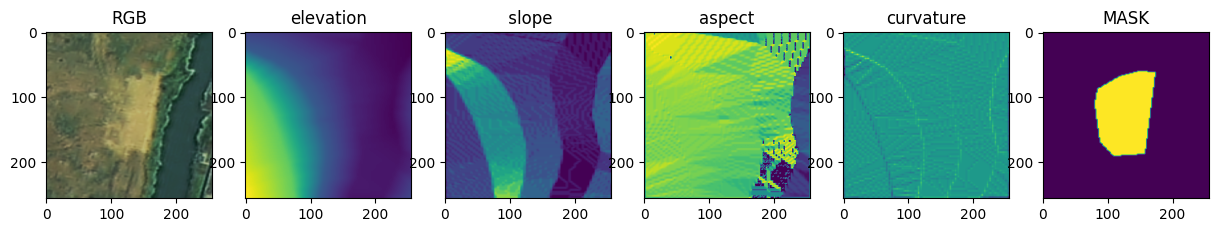

In [41]:
import matplotlib.pyplot as plt

img = 170
fig, axs = plt.subplots(1, 6, figsize=(15, 10))

# 绘制RGB图像
axs[0].set_title("RGB")
axs[0].imshow(TRAIN_XX[img, :, :, 0:3] * 255)  # 乘以255以恢复到0-255范围  # 假设RGB通道分别在0, 1, 2通道

# 绘制NDVI图像
axs[1].set_title("elevation")
axs[1].imshow(TRAIN_XX[img, :, :, 3])  # 假设NDVI在第3个通道

axs[2].set_title(" slope")
axs[2].imshow(TRAIN_XX[img, :, :, 4])  

axs[3].set_title("aspect")
axs[3].imshow(TRAIN_XX[img, :, :, 5])  

axs[4].set_title("curvature")
axs[4].imshow(TRAIN_XX[img, :, :, 6])  

axs[5].set_title("MASK")
axs[5].imshow(TRAIN_YY[img, :, :, 0])  






plt.show()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#划分训练集和测试集
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K
# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#unet模型
def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))
    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

Epoch 1/100

Epoch 1: val_f1_m improved from -inf to 0.00000, saving model to best_model.keras
39/39 - 53s - 1s/step - accuracy: 0.8035 - f1_m: 0.0391 - loss: 0.4045 - precision_m: 0.0586 - recall_m: 0.1090 - val_accuracy: 0.8923 - val_f1_m: 0.0000e+00 - val_loss: 0.2088 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100

Epoch 2: val_f1_m did not improve from 0.00000
39/39 - 45s - 1s/step - accuracy: 0.8944 - f1_m: 1.7856e-05 - loss: 0.2226 - precision_m: 0.0268 - recall_m: 8.9312e-06 - val_accuracy: 0.8923 - val_f1_m: 0.0000e+00 - val_loss: 0.2096 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100

Epoch 3: val_f1_m did not improve from 0.00000
39/39 - 44s - 1s/step - accuracy: 0.8944 - f1_m: 6.1663e-06 - loss: 0.2046 - precision_m: 0.0193 - recall_m: 3.0837e-06 - val_accuracy: 0.8923 - val_f1_m: 0.0000e+00 - val_loss: 0.2200 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100

Epoch 4: val_f1_m improved from 0.00000 to 0.00033, sa

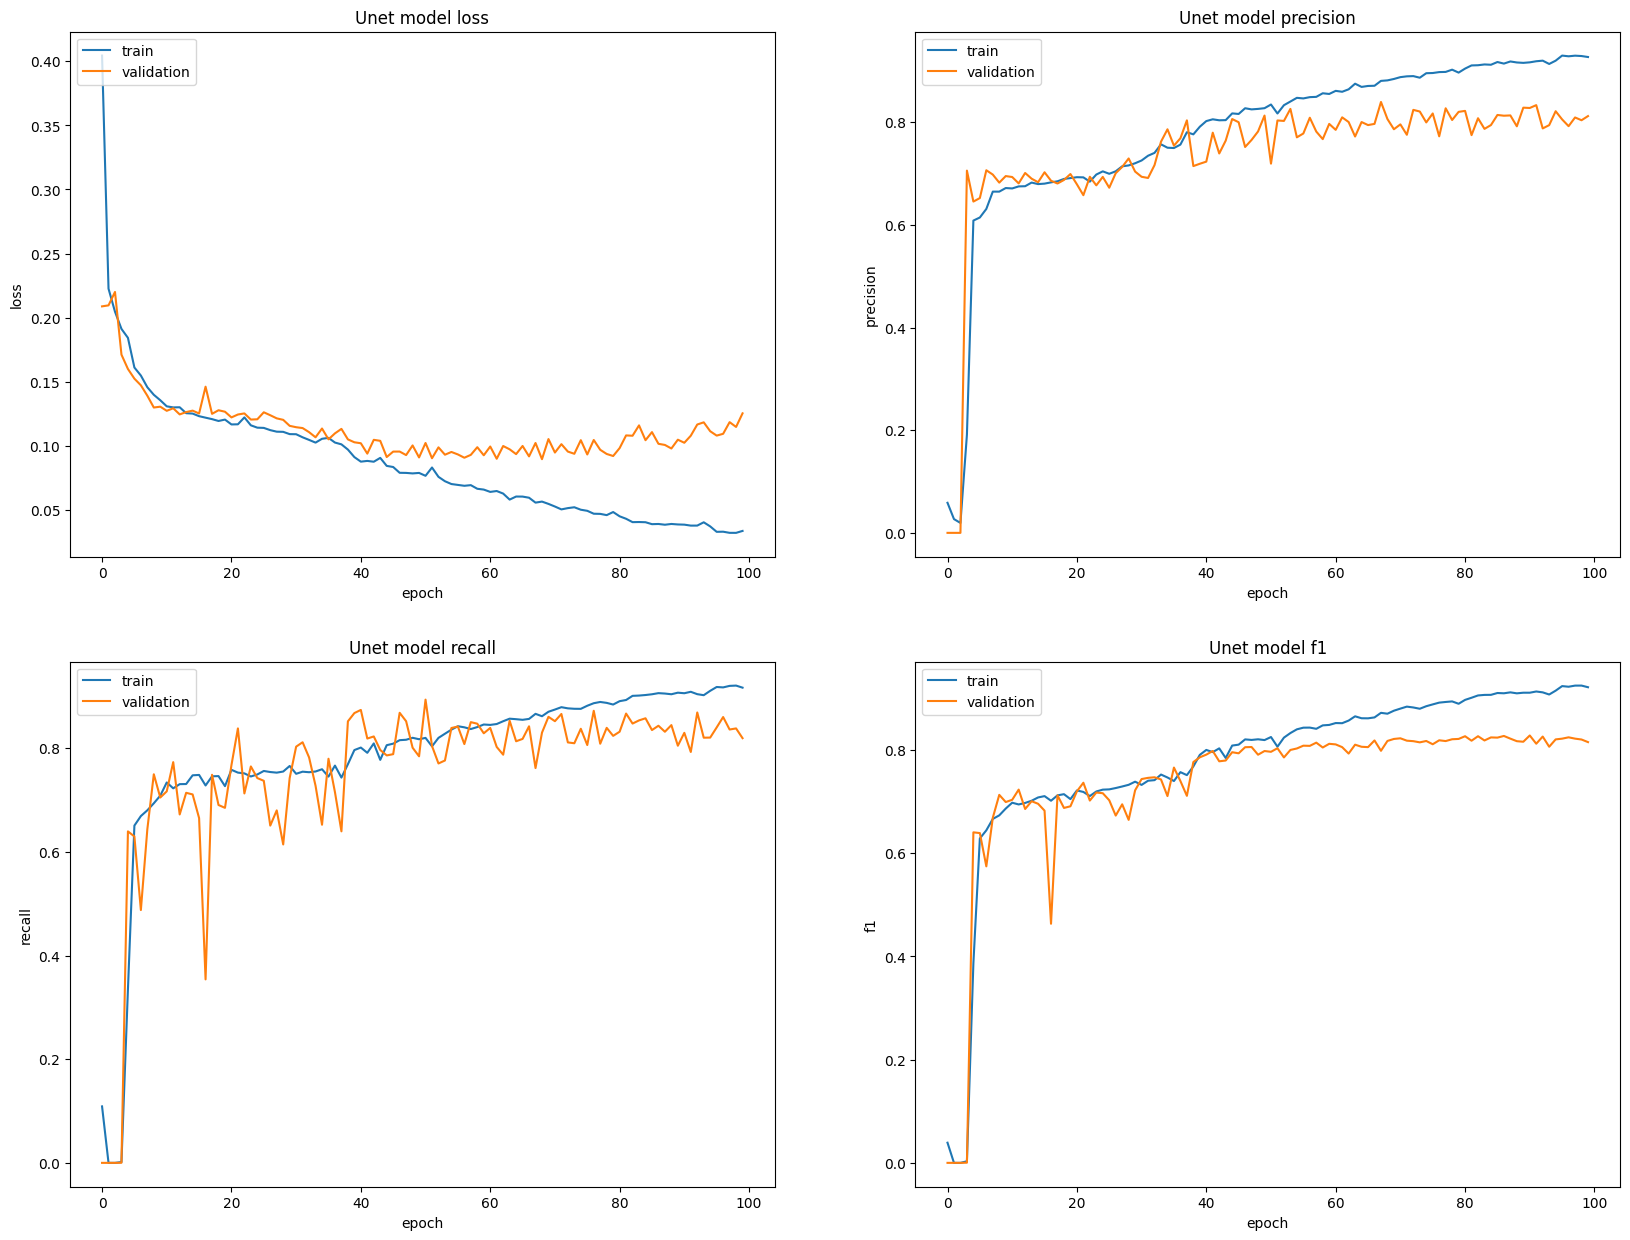

In [6]:

model = unet_model(256, 256, 7)
#回调函数
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
callbacks = [checkpointer]
history = model.fit(x_train, y_train, batch_size=16,
          epochs=100,
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)
model.save("model_save.keras")
#计算评价指标
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print('loss:',loss)
print('accuracy:',accuracy)
print('f1_score:',f1_score)
print('precision:',precision)
print('recall:',recall)

fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step


Text(0.5, 1.0, 'Training Image')

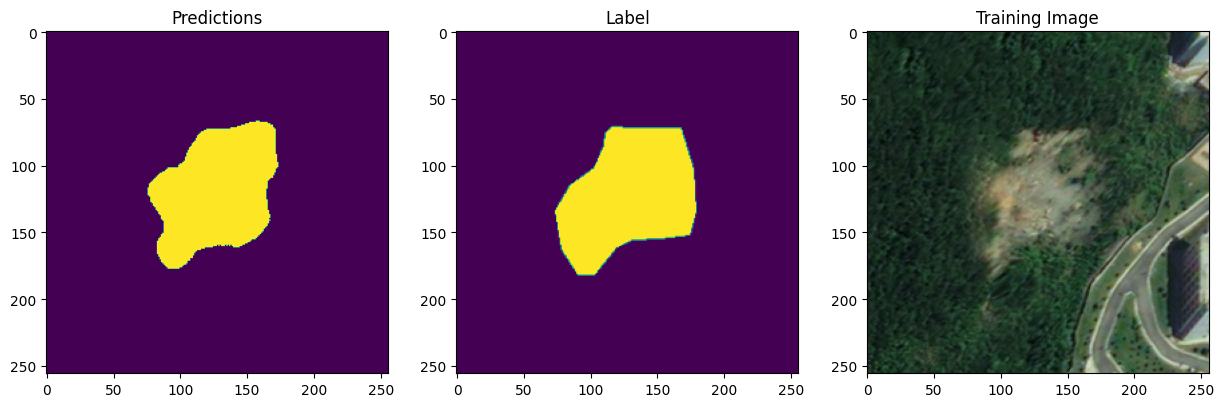

In [34]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)
#选择第77个样本进行可视化
img = 71
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3]*255)
ax3.set_title('Training Image')